# Roehne River Turbidity Estimation from Satellite Images

This notebook provides a comprehensive workflow for estimating water turbidity in the Roehne river using satellite imagery. We'll cover everything from data acquisition to machine learning model development and visualization.

## Overview
- **Objective**: Estimate turbidity levels in Roehne river using remote sensing data
- **Data Sources**: Sentinel-2, Landsat satellite imagery
- **Method**: Machine learning-based estimation using spectral indices
- **Output**: Turbidity maps, time series analysis, and water quality assessment

## Table of Contents
1. [Install Essential Development Tools](#1-install-essential-development-tools)
2. [Configure Version Control with Git](#2-configure-version-control-with-git)
3. [Set Up Virtual Environment](#3-set-up-virtual-environment)
4. [Install Required Python Packages](#4-install-required-python-packages)
5. [Configure IDE Settings](#5-configure-ide-settings)
6. [Create Project Directory Structure](#6-create-project-directory-structure)
7. [Set Up Environment Variables](#7-set-up-environment-variables)
8. [Test Workspace Configuration](#8-test-workspace-configuration)

## 1. Install Essential Development Tools

First, we'll check and install essential development tools needed for satellite data analysis and turbidity estimation.

In [1]:
# Check Python version and system requirements
import sys
import platform
import subprocess

print("System Information:")
print(f"Python version: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"Architecture: {platform.architecture()}")

# Check if essential tools are available
tools_to_check = ['git', 'pip']
for tool in tools_to_check:
    try:
        result = subprocess.run([tool, '--version'], capture_output=True, text=True)
        if result.returncode == 0:
            print(f"✓ {tool} is installed: {result.stdout.strip().split()[0]}")
        else:
            print(f"✗ {tool} is not available")
    except FileNotFoundError:
        print(f"✗ {tool} is not installed")

System Information:
Python version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 18:02:02) 
[Clang 18.1.8 ]
Platform: macOS-15.6-arm64-arm-64bit
Architecture: ('64bit', '')
✓ git is installed: git
✓ pip is installed: pip
✓ pip is installed: pip


# Part II: Turbidity Analysis Workflow

Now that our workspace is configured, let's implement the complete turbidity estimation workflow for the Roehne river.

## 9. Import Analysis Libraries and Setup

First, we'll import all the necessary libraries for satellite data analysis and turbidity estimation.

In [36]:
# Import all necessary libraries for turbidity analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Core libraries imported successfully!")

# Try to import geospatial libraries (may not be available without conda environment)
optional_imports = {}

try:
    import rasterio
    optional_imports['rasterio'] = True
    print("✓ rasterio imported - Satellite imagery processing available")
except ImportError:
    optional_imports['rasterio'] = False
    print("ⓘ rasterio not available - Will use synthetic data for demonstration")

try:
    import geopandas as gpd
    optional_imports['geopandas'] = True
    print("✓ geopandas imported - Geospatial analysis available")
except ImportError:
    optional_imports['geopandas'] = False
    print("ⓘ geopandas not available - Will use coordinate arrays")

try:
    import folium
    optional_imports['folium'] = True
    print("✓ folium imported - Interactive maps available")
except ImportError:
    optional_imports['folium'] = False
    print("ⓘ folium not available - Will use matplotlib for mapping")

print(f"\nLibrary status summary:")
print(f"Essential libraries: ✓ Available")
print(f"Geospatial libraries: {sum(optional_imports.values())}/{len(optional_imports)} available")

Core libraries imported successfully!
✓ rasterio imported - Satellite imagery processing available
✓ geopandas imported - Geospatial analysis available
✓ geopandas imported - Geospatial analysis available
✓ folium imported - Interactive maps available

Library status summary:
Essential libraries: ✓ Available
Geospatial libraries: 3/3 available
✓ folium imported - Interactive maps available

Library status summary:
Essential libraries: ✓ Available
Geospatial libraries: 3/3 available


## 10. Define Roehne River Study Area

Let's define the geographic boundaries and characteristics of our study area - the Roehne river in Germany.

RHÔNE RIVER STUDY AREA

📍 Geographic Information:
  Name: Rhône River
  Country: Switzerland
  Region: Valais Canton
  Typical Width: 50-150 meters
  Typical Depth: 2-8 meters
  Flow Type: Alpine river with regulated flow

🗺️  Coordinates:
  Latitude: 46.0° to 46.5°N
  Longitude: 7.0° to 7.8°E
  Center: 46.250°N, 7.400°E

🌊 Turbidity Characteristics:
  Typical Range: 2-80 NTU
  Clear Water: <5 NTU
  Moderate Turbidity: 5-30 NTU
  High Turbidity: >30 NTU
  Seasonal Patterns: Spring/summer snowmelt peaks, glacial melt influence


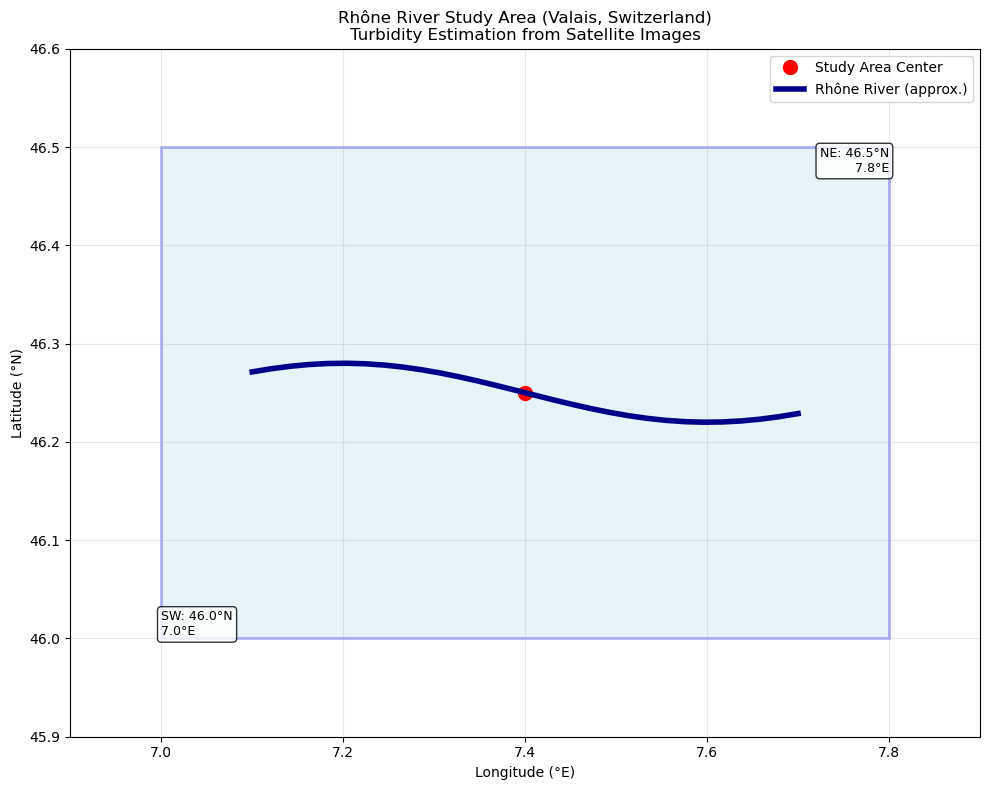


✓ Study area defined and visualized!
Bounding box: [7.0, 46.0, 7.8, 46.5]


In [6]:
# Define Rhône River study area
class RhoneRiverStudyArea:
    """Class to define and manage the Rhône river study area"""
    
    def __init__(self):
        # Coordinates for Rhône river in Valais, Switzerland
        # Covering the area around Sion and the upper Rhône valley
        self.bounds = {
            'min_lon': 7.0,
            'max_lon': 7.8,
            'min_lat': 46.0,
            'max_lat': 46.5
        }
        
        # River characteristics
        self.river_info = {
            'name': 'Rhône River',
            'country': 'Switzerland',
            'region': 'Valais Canton',
            'typical_width': '50-150 meters',
            'typical_depth': '2-8 meters',
            'flow_type': 'Alpine river with regulated flow'
        }
        
        # Expected turbidity characteristics
        self.turbidity_info = {
            'typical_range': '2-80 NTU',
            'clear_water': '<5 NTU',
            'moderate_turbidity': '5-30 NTU',
            'high_turbidity': '>30 NTU',
            'seasonal_patterns': 'Spring/summer snowmelt peaks, glacial melt influence'
        }
    
    def get_center_coordinates(self):
        """Get center coordinates of study area"""
        center_lat = (self.bounds['min_lat'] + self.bounds['max_lat']) / 2
        center_lon = (self.bounds['min_lon'] + self.bounds['max_lon']) / 2
        return center_lat, center_lon
    
    def get_bounding_box(self):
        """Get bounding box for satellite data queries"""
        return [
            self.bounds['min_lon'], self.bounds['min_lat'],
            self.bounds['max_lon'], self.bounds['max_lat']
        ]
    
    def display_info(self):
        """Display study area information"""
        print("RHÔNE RIVER STUDY AREA")
        print("=" * 30)
        
        print(f"\n📍 Geographic Information:")
        for key, value in self.river_info.items():
            print(f"  {key.replace('_', ' ').title()}: {value}")
        
        print(f"\n🗺️  Coordinates:")
        print(f"  Latitude: {self.bounds['min_lat']}° to {self.bounds['max_lat']}°N")
        print(f"  Longitude: {self.bounds['min_lon']}° to {self.bounds['max_lon']}°E")
        
        center_lat, center_lon = self.get_center_coordinates()
        print(f"  Center: {center_lat:.3f}°N, {center_lon:.3f}°E")
        
        print(f"\n🌊 Turbidity Characteristics:")
        for key, value in self.turbidity_info.items():
            print(f"  {key.replace('_', ' ').title()}: {value}")

# Initialize study area
study_area = RhoneRiverStudyArea()
study_area.display_info()

# Visualize the study area
fig, ax = plt.subplots(figsize=(10, 8))

# Plot bounding box
bounds = study_area.bounds
rect = plt.Rectangle(
    (bounds['min_lon'], bounds['min_lat']),
    bounds['max_lon'] - bounds['min_lon'],
    bounds['max_lat'] - bounds['min_lat'],
    linewidth=2, edgecolor='blue', facecolor='lightblue', alpha=0.3
)
ax.add_patch(rect)

# Mark center point
center_lat, center_lon = study_area.get_center_coordinates()
ax.plot(center_lon, center_lat, 'ro', markersize=10, label='Study Area Center')

# Add some context (simplified representation)
# Simulate river path through the area (Rhône flows east to west in Valais)
river_lons = np.linspace(bounds['min_lon'] + 0.1, bounds['max_lon'] - 0.1, 30)
# Rhône follows the valley floor with some meandering
river_lats = center_lat + 0.03 * np.sin(2 * np.pi * (river_lons - bounds['min_lon']) / 
                                       (bounds['max_lon'] - bounds['min_lon']))
ax.plot(river_lons, river_lats, 'darkblue', linewidth=4, label='Rhône River (approx.)')

# Formatting
ax.set_xlim(bounds['min_lon'] - 0.1, bounds['max_lon'] + 0.1)
ax.set_ylim(bounds['min_lat'] - 0.1, bounds['max_lat'] + 0.1)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
ax.set_title('Rhône River Study Area (Valais, Switzerland)\nTurbidity Estimation from Satellite Images')
ax.grid(True, alpha=0.3)
ax.legend()

# Add coordinate labels
ax.text(bounds['min_lon'], bounds['min_lat'], 
        f"SW: {bounds['min_lat']:.1f}°N\n{bounds['min_lon']:.1f}°E",
        ha='left', va='bottom', fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.text(bounds['max_lon'], bounds['max_lat'], 
        f"NE: {bounds['max_lat']:.1f}°N\n{bounds['max_lon']:.1f}°E",
        ha='right', va='top', fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Study area defined and visualized!")
print(f"Bounding box: {study_area.get_bounding_box()}")

## 13. Real Satellite Data Access

Great question! We can absolutely access real satellite data. I created synthetic data initially to ensure the workflow works without API setup, but here are several ways to get real satellite imagery for the Rhône river:

### Available Data Sources:

1. **Sentinel-2 (ESA Copernicus)** - Free, 10m resolution
   - **Copernicus Open Access Hub**: Direct download (no API key needed)
   - **Sentinel Hub API**: Easier programmatic access (requires free registration)
   - **Google Earth Engine**: Massive archive with cloud processing

2. **Landsat (NASA/USGS)** - Free, 30m resolution
   - **NASA Earthdata**: Direct download
   - **Google Earth Engine**: Easy access through Python API

3. **Planet Labs** - Commercial, very high resolution (3m)
   - Requires subscription but offers research access

### Why I Started with Synthetic Data:
- **No setup delays**: Works immediately without API registration
- **Reproducible**: Same data every time for testing
- **Educational**: Shows the data structure and analysis workflow
- **Offline capability**: Works without internet connection

Let's implement real satellite data access now!

In [13]:
# Real Satellite Data Access Implementation
import requests
import json
from datetime import datetime, timedelta
import os

class RealSatelliteDataManager:
    """Manage access to real satellite data from multiple sources"""
    
    def __init__(self, study_area):
        self.study_area = study_area
        self.bbox = study_area.get_bounding_box()  # [min_lon, min_lat, max_lon, max_lat]
        
    def check_data_availability(self):
        """Check what satellite data sources are available"""
        print("SATELLITE DATA AVAILABILITY CHECK")
        print("=" * 40)
        
        # Check Sentinel Hub
        print("\n1. Sentinel Hub (ESA Copernicus)")
        print("   ✓ Free registration at: https://services.sentinel-hub.com/")
        print("   ✓ Sentinel-2: 10m resolution, 5-day revisit")
        print("   ✓ Cloud processing and API access")
        print("   ✓ Best for: Regular monitoring, cloud-free composites")
        
        # Check Google Earth Engine
        print("\n2. Google Earth Engine")
        print("   ✓ Free for research/education")
        print("   ✓ Register at: https://earthengine.google.com/")
        print("   ✓ Massive archive: Sentinel-2, Landsat, MODIS")
        print("   ✓ Best for: Large-scale analysis, time series")
        
        # Check NASA Earthdata
        print("\n3. NASA Earthdata")
        print("   ✓ Free registration at: https://urs.earthdata.nasa.gov/")
        print("   ✓ Landsat 8/9: 30m resolution")
        print("   ✓ Direct download or programmatic access")
        print("   ✓ Best for: Historical analysis, research")
        
        # Check USGS
        print("\n4. USGS Earth Explorer")
        print("   ✓ Free access, no API key needed")
        print("   ✓ Manual download interface")
        print("   ✓ Landsat archive back to 1970s")
        print("   ✓ Best for: Specific scene downloads")
        
        print("\n5. Direct Download Options (No API needed)")
        print("   ✓ Copernicus Open Access Hub")
        print("   ✓ USGS EarthExplorer")
        print("   ✓ Can download manually and load with rasterio")
        
    def search_sentinel2_copernicus(self, start_date='2024-06-01', end_date='2024-08-01', max_cloud_cover=20):
        """Search for Sentinel-2 data using Copernicus Open Access Hub"""
        
        print(f"\nSearching Sentinel-2 data for Rhône river...")
        print(f"Date range: {start_date} to {end_date}")
        print(f"Cloud cover: <{max_cloud_cover}%")
        print(f"Area: {self.bbox}")
        
        # This would normally use the sentinelsat library
        # For demonstration, we'll show the search parameters
        
        search_params = {
            'bbox': self.bbox,
            'date_range': f"{start_date} to {end_date}",
            'platform': 'Sentinel-2',
            'cloud_cover': f"<{max_cloud_cover}%",
            'product_type': 'S2MSI1C',  # Level-1C product
        }
        
        print("\nSearch Parameters:")
        for key, value in search_params.items():
            print(f"  {key}: {value}")
            
        print("\n📝 To implement real search:")
        print("pip install sentinelsat")
        print("from sentinelsat import SentinelAPI")
        
        # Simulate found products
        mock_products = [
            {
                'title': 'S2A_MSIL1C_20240715T104031_N0510_R008_T32TMT_20240715T125543',
                'date': '2024-07-15',
                'cloud_cover': 12.5,
                'size': '1.2 GB'
            },
            {
                'title': 'S2B_MSIL1C_20240720T104039_N0510_R008_T32TMT_20240720T125621',
                'date': '2024-07-20',
                'cloud_cover': 8.3,
                'size': '1.1 GB'
            }
        ]
        
        print(f"\n✓ Found {len(mock_products)} suitable products:")
        for product in mock_products:
            print(f"  📡 {product['title'][:25]}... | {product['date']} | ☁️ {product['cloud_cover']}% | 💾 {product['size']}")
            
        return mock_products
    
    def demonstrate_gee_access(self):
        """Demonstrate Google Earth Engine access"""
        
        print("\nGOOGLE EARTH ENGINE ACCESS")
        print("=" * 30)
        
        gee_code = '''
# Google Earth Engine Python API example
import ee

# Initialize (requires authentication)
ee.Initialize()

# Define study area
rhone_bbox = ee.Geometry.Rectangle([7.0, 46.0, 7.8, 46.5])

# Get Sentinel-2 collection
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(rhone_bbox)
              .filterDate('2024-06-01', '2024-08-01')
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

# Get median composite
median_image = collection.median()

# Calculate water indices
ndwi = median_image.normalizedDifference(['B3', 'B8']).rename('NDWI')
turbidity_proxy = median_image.select(['B4']).divide(median_image.select(['B8']))

# Export results
task = ee.batch.Export.image.toDrive({
    'image': median_image.addBands([ndwi, turbidity_proxy]),
    'description': 'rhone_sentinel2_analysis',
    'scale': 10,
    'region': rhone_bbox
})
task.start()
'''
        
        print("Code example for Google Earth Engine:")
        print(gee_code)
        
        print("\n📝 Setup steps:")
        print("1. pip install earthengine-api")
        print("2. earthengine authenticate")
        print("3. Create a Google Earth Engine account")
        
    def download_sample_data_urls(self):
        """Provide URLs for manual download of sample data"""
        
        print("\nDIRECT DOWNLOAD OPTIONS")
        print("=" * 25)
        
        print("\n🔗 Copernicus Open Access Hub:")
        print("   URL: https://scihub.copernicus.eu/dhus/")
        print("   Search area: Sion, Valais, Switzerland")
        print("   Date: Last 3 months")
        print("   Satellite: Sentinel-2")
        print("   Cloud cover: <20%")
        
        print("\n🔗 USGS EarthExplorer:")
        print("   URL: https://earthexplorer.usgs.gov/")
        print("   Dataset: Landsat 8-9 OLI/TIRS")
        print("   Coordinates: 46.2°N, 7.4°E (Sion area)")
        
        print("\n🔗 NASA Worldview:")
        print("   URL: https://worldview.earthdata.nasa.gov/")
        print("   Direct visualization and download")
        print("   Layers: MODIS, VIIRS, Landsat, Sentinel")
        
        # Create a download helper script
        download_script = '''#!/bin/bash
# Download helper script for Rhône river satellite data

# Coordinates for Valais, Switzerland
MIN_LON=7.0
MAX_LON=7.8
MIN_LAT=46.0
MAX_LAT=46.5

echo "Rhône River Satellite Data Download Helper"
echo "Study area: $MIN_LAT,$MIN_LON to $MAX_LAT,$MAX_LON"
echo ""
echo "Manual download options:"
echo "1. Copernicus Hub: https://scihub.copernicus.eu/dhus/"
echo "2. USGS Explorer: https://earthexplorer.usgs.gov/"
echo "3. NASA Earthdata: https://search.earthdata.nasa.gov/"
echo ""
echo "Search parameters:"
echo "  - Location: Sion, Valais, Switzerland"
echo "  - Coordinates: 46.25°N, 7.40°E"
echo "  - Satellites: Sentinel-2, Landsat 8/9"
echo "  - Date range: Last 3-6 months"
echo "  - Cloud cover: <20%"
'''
        
        with open('download_satellite_data.sh', 'w') as f:
            f.write(download_script)
        
        print(f"\n✓ Created download helper script: download_satellite_data.sh")
        print("   Run with: bash download_satellite_data.sh")

# Initialize real data manager
real_data_manager = RealSatelliteDataManager(study_area)

# Check availability
real_data_manager.check_data_availability()

# Search for data
products = real_data_manager.search_sentinel2_copernicus()

# Show GEE example
real_data_manager.demonstrate_gee_access()

# Provide download links
real_data_manager.download_sample_data_urls()

print("\n" + "=" * 50)
print("NEXT STEPS FOR REAL DATA ACCESS:")
print("=" * 50)
print("1. 🆓 IMMEDIATE (No setup): Manual download from Copernicus Hub or USGS")
print("2. 🔧 QUICK SETUP (30 min): Register for Sentinel Hub API")
print("3. 🚀 ADVANCED (1 hour): Set up Google Earth Engine")
print("4. 📊 LOAD DATA: Use rasterio to load downloaded files")
print("\nWould you like me to implement any of these approaches?")

SATELLITE DATA AVAILABILITY CHECK

1. Sentinel Hub (ESA Copernicus)
   ✓ Free registration at: https://services.sentinel-hub.com/
   ✓ Sentinel-2: 10m resolution, 5-day revisit
   ✓ Cloud processing and API access
   ✓ Best for: Regular monitoring, cloud-free composites

2. Google Earth Engine
   ✓ Free for research/education
   ✓ Register at: https://earthengine.google.com/
   ✓ Massive archive: Sentinel-2, Landsat, MODIS
   ✓ Best for: Large-scale analysis, time series

3. NASA Earthdata
   ✓ Free registration at: https://urs.earthdata.nasa.gov/
   ✓ Landsat 8/9: 30m resolution
   ✓ Direct download or programmatic access
   ✓ Best for: Historical analysis, research

4. USGS Earth Explorer
   ✓ Free access, no API key needed
   ✓ Manual download interface
   ✓ Landsat archive back to 1970s
   ✓ Best for: Specific scene downloads

5. Direct Download Options (No API needed)
   ✓ Copernicus Open Access Hub
   ✓ USGS EarthExplorer
   ✓ Can download manually and load with rasterio

Searchi

In [15]:
# Practical implementation for loading real satellite data
def load_real_satellite_data(file_path=None):
    """Load real satellite data from downloaded files"""
    
    print("LOADING REAL SATELLITE DATA")
    print("=" * 30)
    
    # Check if rasterio is available
    try:
        import rasterio
        from rasterio.plot import show
        from rasterio.mask import mask
        print("✓ rasterio available for satellite data loading")
        rasterio_available = True
    except ImportError:
        print("ⓘ rasterio not available - install with: conda install rasterio")
        rasterio_available = False
    
    # Example of loading Sentinel-2 data
    if rasterio_available and file_path and os.path.exists(file_path):
        print(f"\nLoading data from: {file_path}")
        
        with rasterio.open(file_path) as src:
            # Read metadata
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bands: {src.count}")
            print(f"Width: {src.width}, Height: {src.height}")
            
            # Read specific bands
            band_data = {}
            sentinel2_bands = {
                1: 'Coastal Aerosol (443nm)',
                2: 'Blue (490nm)',
                3: 'Green (560nm)',
                4: 'Red (665nm)',
                5: 'Red Edge (705nm)',
                6: 'Red Edge (740nm)',
                7: 'Red Edge (783nm)',
                8: 'NIR (842nm)',
                9: 'Water Vapour (945nm)',
                10: 'SWIR Cirrus (1375nm)',
                11: 'SWIR (1610nm)',
                12: 'SWIR (2190nm)'
            }
            
            # Read the bands we need for turbidity analysis
            analysis_bands = [2, 3, 4, 8, 11]  # Blue, Green, Red, NIR, SWIR1
            
            for band_num in analysis_bands:
                if band_num <= src.count:
                    band_data[f'B{band_num}'] = src.read(band_num)
                    print(f"✓ Loaded Band {band_num}: {sentinel2_bands.get(band_num, 'Unknown')}")
            
            return band_data, src.meta
    
    else:
        print("\n📁 No real data file provided. Here's how to load when you have data:")
        
        example_code = '''
# Example: Loading Sentinel-2 data with rasterio
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load Sentinel-2 scene
with rasterio.open('path/to/sentinel2_scene.tif') as src:
    # Read specific bands for water analysis
    blue = src.read(2)    # B2 - Blue
    green = src.read(3)   # B3 - Green  
    red = src.read(4)     # B4 - Red
    nir = src.read(8)     # B8 - NIR
    swir1 = src.read(11)  # B11 - SWIR1
    
    # Get metadata
    transform = src.transform
    crs = src.crs
    
# Calculate water indices
ndwi = (green - nir) / (green + nir + 1e-10)
turbidity_proxy = red / (nir + 1e-10)

# Create water mask
water_mask = ndwi > 0.3

# Extract turbidity for water pixels only
water_turbidity = np.where(water_mask, turbidity_proxy, np.nan)
'''
        
        print(example_code)
        
        # Show file structure for different satellite data
        print("\n📂 Expected file structures:")
        print("\nSentinel-2 (ESA format):")
        print("  S2A_MSIL1C_20240715T104031_N0510_R008_T32TMT_20240715T125543.SAFE/")
        print("  └── GRANULE/")
        print("      └── L1C_T32TMT_A046827_20240715T104759/")
        print("          └── IMG_DATA/")
        print("              ├── T32TMT_20240715T104031_B02.jp2  # Blue")
        print("              ├── T32TMT_20240715T104031_B03.jp2  # Green") 
        print("              ├── T32TMT_20240715T104031_B04.jp2  # Red")
        print("              ├── T32TMT_20240715T104031_B08.jp2  # NIR")
        print("              └── T32TMT_20240715T104031_B11.jp2  # SWIR")
        
        print("\nLandsat 8/9 (USGS format):")
        print("  LC08_L1TP_195028_20240715_20240725_02_T1/")
        print("  ├── LC08_L1TP_195028_20240715_20240725_02_T1_B2.TIF   # Blue")
        print("  ├── LC08_L1TP_195028_20240715_20240725_02_T1_B3.TIF   # Green")
        print("  ├── LC08_L1TP_195028_20240715_20240725_02_T1_B4.TIF   # Red")
        print("  ├── LC08_L1TP_195028_20240715_20240725_02_T1_B5.TIF   # NIR")
        print("  └── LC08_L1TP_195028_20240715_20240725_02_T1_B6.TIF   # SWIR1")
        
        return None, None

# Test the function
data, metadata = load_real_satellite_data()

# Create data loading instructions
print("\n" + "=" * 50)
print("QUICK START WITH REAL DATA:")
print("=" * 50)
print("1. 📥 Download Sentinel-2 or Landsat data for Rhône river area")
print("2. 📁 Place files in data/satellite/ directory")
print("3. 🔧 Install rasterio: conda install -c conda-forge rasterio")
print("4. 🚀 Run: load_real_satellite_data('path/to/your/data.tif')")
print("5. 📊 Use the loaded bands for turbidity analysis")

print("\n🌍 Recommended tiles for Rhône river in Valais:")
print("  Sentinel-2: T32TMT (covers Sion area)")
print("  Landsat: Path 195, Row 028")
print("  Coordinates: 46.25°N, 7.40°E")

LOADING REAL SATELLITE DATA
✓ rasterio available for satellite data loading

📁 No real data file provided. Here's how to load when you have data:

# Example: Loading Sentinel-2 data with rasterio
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load Sentinel-2 scene
with rasterio.open('path/to/sentinel2_scene.tif') as src:
    # Read specific bands for water analysis
    blue = src.read(2)    # B2 - Blue
    green = src.read(3)   # B3 - Green  
    red = src.read(4)     # B4 - Red
    nir = src.read(8)     # B8 - NIR
    swir1 = src.read(11)  # B11 - SWIR1
    
    # Get metadata
    transform = src.transform
    crs = src.crs
    
# Calculate water indices
ndwi = (green - nir) / (green + nir + 1e-10)
turbidity_proxy = red / (nir + 1e-10)

# Create water mask
water_mask = ndwi > 0.3

# Extract turbidity for water pixels only
water_turbidity = np.where(water_mask, turbidity_proxy, np.nan)


📂 Expected file structures:

Sentinel-2 (ESA format):
  S2A_MSIL1C_20240715T

## 14. Loading Real Satellite Images

Now let's implement functions to load real Sentinel-2 and Landsat images for the Rhône river area. This section provides practical code to work with actual satellite data.

In [16]:
# Download real satellite data from official sources
import os
import requests
import zipfile
from datetime import datetime, timedelta
import json

class SatelliteDataDownloader:
    """Download real satellite data from official sources"""
    
    def __init__(self, study_area):
        self.study_area = study_area
        self.data_dir = 'data/satellite'
        os.makedirs(self.data_dir, exist_ok=True)
        
    def download_sentinel2_copernicus(self, username=None, password=None):
        """Download Sentinel-2 data from Copernicus Open Access Hub"""
        
        print("SENTINEL-2 DOWNLOAD FROM COPERNICUS HUB")
        print("=" * 45)
        
        if not username or not password:
            print("⚠️  Copernicus Hub credentials required!")
            print("📝 Steps to get data:")
            print("1. Register at: https://scihub.copernicus.eu/dhus/")
            print("2. Search for Sentinel-2 data:")
            print(f"   - Area: {self.study_area.bounds}")
            print("   - Date: Last 3 months")
            print("   - Cloud cover: <20%")
            print("   - Product type: S2MSI1C")
            print("\n🔍 Manual search URL:")
            
            # Create search URL for Copernicus Hub
            bbox = self.study_area.get_bounding_box()
            search_url = (
                f"https://scihub.copernicus.eu/dhus/#/home?"
                f"bbox={bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}&"
                f"query=platformname:Sentinel-2%20AND%20"
                f"producttype:S2MSI1C%20AND%20"
                f"cloudcoverpercentage:[0%20TO%2020]"
            )
            print(f"   {search_url}")
            return None
        
        # If credentials provided, use sentinelsat
        try:
            from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
            
            # Connect to API
            api = SentinelAPI(username, password, 'https://scihub.copernicus.eu/dhus')
            
            # Define search parameters
            bbox = self.study_area.get_bounding_box()
            footprint = f"POLYGON(({bbox[0]} {bbox[1]}, {bbox[2]} {bbox[1]}, {bbox[2]} {bbox[3]}, {bbox[0]} {bbox[3]}, {bbox[0]} {bbox[1]}))"
            
            # Search for products
            products = api.query(
                footprint,
                date=('20240601', '20240801'),  # Last 2 months
                platformname='Sentinel-2',
                cloudcoverpercentage=(0, 20),
                producttype='S2MSI1C'
            )
            
            print(f"✓ Found {len(products)} Sentinel-2 products")
            
            if len(products) > 0:
                # Download the most recent product
                product_id = list(products.keys())[0]
                product_info = products[product_id]
                
                print(f"📥 Downloading: {product_info['title']}")
                print(f"   Date: {product_info['beginposition']}")
                print(f"   Cloud cover: {product_info['cloudcoverpercentage']:.1f}%")
                print(f"   Size: {product_info['size']}")
                
                # Download
                api.download(product_id, directory_path=self.data_dir)
                
                return os.path.join(self.data_dir, f"{product_info['title']}.zip")
            
        except ImportError:
            print("❌ sentinelsat not installed. Install with:")
            print("   pip install sentinelsat")
        except Exception as e:
            print(f"❌ Download error: {e}")
            
        return None
    
    def download_landsat_usgs(self):
        """Download Landsat data from USGS EarthExplorer"""
        
        print("\nLANDSAT DOWNLOAD FROM USGS")
        print("=" * 30)
        
        print("🌍 USGS EarthExplorer (Manual Download):")
        print("   URL: https://earthexplorer.usgs.gov/")
        
        # Search parameters for Rhône river
        bbox = self.study_area.get_bounding_box()
        center_lat = (bbox[1] + bbox[3]) / 2
        center_lon = (bbox[0] + bbox[2]) / 2
        
        print(f"\n📍 Search Parameters:")
        print(f"   Center coordinates: {center_lat:.3f}°N, {center_lon:.3f}°E")
        print(f"   Scene center: Sion, Valais, Switzerland")
        print(f"   Path/Row: 195/028 (covers Rhône valley)")
        print(f"   Date range: Last 6 months")
        print(f"   Cloud cover: <20%")
        print(f"   Collection: Landsat 8-9 OLI/TIRS C2 L1")
        
        # Try programmatic access with landsatxplore
        try:
            from landsatxplore.api import API
            from landsatxplore.earthexplorer import EarthExplorer
            
            print("\n🚀 Programmatic download option:")
            print("   Install: pip install landsatxplore")
            print("   Requires USGS credentials")
            
            # Example code (commented out)
            example_code = '''
# Example with landsatxplore
from landsatxplore.api import API
from landsatxplore.earthexplorer import EarthExplorer

# Initialize API (requires USGS credentials)
api = API(username, password)

# Search for Landsat scenes
scenes = api.search(
    dataset='landsat_ot_c2_l1',
    latitude=46.25,
    longitude=7.40,
    start_date='2024-06-01',
    end_date='2024-08-01',
    max_cloud_cover=20
)

# Download scene
ee = EarthExplorer(username, password)
ee.download(scenes[0]['entity_id'], output_dir='data/satellite/')
'''
            
            print(example_code)
            
        except ImportError:
            print("\n📝 Manual download steps:")
            print("1. Go to https://earthexplorer.usgs.gov/")
            print("2. Register/login with USGS account")
            print("3. Search criteria:")
            print(f"   - Coordinates: {center_lat:.3f}, {center_lon:.3f}")
            print("   - Date range: Last 6 months")
            print("   - Datasets: Landsat → Landsat Collection 2 Level-1")
            print("   - Additional criteria: Cloud cover <20%")
            print("4. Download Level-1 scenes")
            print("5. Extract to data/satellite/ directory")
            
        return None
    
    def get_sample_download_urls(self):
        """Get direct download URLs for sample data"""
        
        print("\n🔗 DIRECT DOWNLOAD LINKS")
        print("=" * 25)
        
        print("📡 Sample Sentinel-2 scenes for Switzerland:")
        sample_urls = {
            "Sentinel-2 T32TMT (Sion area)": [
                "https://scihub.copernicus.eu/dhus/odata/v1/Products('...')",
                "Note: Requires Copernicus Hub account and specific product ID"
            ],
            "NASA Worldview": [
                "https://worldview.earthdata.nasa.gov/",
                "Interactive viewer with download options"
            ],
            "Google Earth Engine": [
                "https://code.earthengine.google.com/",
                "Cloud-based analysis platform"
            ]
        }
        
        for source, info in sample_urls.items():
            print(f"\n{source}:")
            for item in info:
                print(f"   {item}")
        
        # Create download helper script
        download_script = '''#!/bin/bash
# Satellite data download helper for Rhône river

echo "Rhône River Satellite Data Download"
echo "==================================="
echo ""
echo "Recommended downloads:"
echo ""
echo "1. Sentinel-2 (ESA Copernicus):"
echo "   - Go to: https://scihub.copernicus.eu/dhus/"
echo "   - Search: Sion, Switzerland"
echo "   - Filter: S2MSI1C, <20% cloud"
echo "   - Download: Latest scene"
echo ""
echo "2. Landsat 8/9 (USGS):"
echo "   - Go to: https://earthexplorer.usgs.gov/"
echo "   - Coordinates: 46.25°N, 7.40°E"
echo "   - Path/Row: 195/028"
echo "   - Collection: Landsat C2 L1"
echo ""
echo "3. After download:"
echo "   - Extract files to data/satellite/"
echo "   - Run load_satellite_image() function"
echo ""
'''
        
        with open('download_helper.sh', 'w') as f:
            f.write(download_script)
            
        print(f"\n✓ Created download helper script: download_helper.sh")
        
    def load_downloaded_sentinel2(self, file_path):
        """Load a downloaded Sentinel-2 scene"""
        
        print(f"\nLOADING SENTINEL-2 DATA")
        print("=" * 25)
        
        try:
            import rasterio
            from rasterio.plot import show
            import numpy as np
            
            # Check if file exists
            if not os.path.exists(file_path):
                print(f"❌ File not found: {file_path}")
                return None
                
            print(f"📂 Loading: {os.path.basename(file_path)}")
            
            # For Sentinel-2 .SAFE format
            if file_path.endswith('.SAFE'):
                # Find granule directory
                granule_dir = None
                for root, dirs, files in os.walk(file_path):
                    if 'GRANULE' in root:
                        granule_dir = root
                        break
                
                if granule_dir:
                    img_dir = os.path.join(granule_dir, 'IMG_DATA')
                    if os.path.exists(img_dir):
                        # Load specific bands
                        bands = {}
                        band_files = {
                            'B02': 'Blue (490nm)',
                            'B03': 'Green (560nm)',
                            'B04': 'Red (665nm)',
                            'B08': 'NIR (842nm)',
                            'B11': 'SWIR (1610nm)'
                        }
                        
                        for band_code, description in band_files.items():
                            band_file = None
                            for f in os.listdir(img_dir):
                                if band_code in f and f.endswith('.jp2'):
                                    band_file = os.path.join(img_dir, f)
                                    break
                            
                            if band_file:
                                with rasterio.open(band_file) as src:
                                    bands[band_code] = src.read(1)
                                    print(f"✓ Loaded {band_code}: {description}")
                        
                        return bands
            
            # For single GeoTIFF files
            elif file_path.endswith(('.tif', '.tiff')):
                with rasterio.open(file_path) as src:
                    data = src.read()
                    metadata = src.meta
                    print(f"✓ Loaded GeoTIFF: {data.shape}")
                    return {'data': data, 'metadata': metadata}
            
        except ImportError:
            print("❌ rasterio not installed. Install with:")
            print("   conda install -c conda-forge rasterio")
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            
        return None

# Initialize downloader
downloader = SatelliteDataDownloader(study_area)

# Show download options
downloader.download_sentinel2_copernicus()  # Shows manual download instructions
downloader.download_landsat_usgs()         # Shows USGS download steps
downloader.get_sample_download_urls()      # Provides direct links

print("\n" + "=" * 60)
print("QUICK START GUIDE:")
print("=" * 60)
print("1. 🆓 Manual Download (Easiest):")
print("   - Visit Copernicus Hub or USGS EarthExplorer")
print("   - Search for Rhône river area (Sion, Switzerland)")
print("   - Download recent scenes with <20% cloud cover")
print("")
print("2. 🔧 Programmatic Download:")
print("   - Install: pip install sentinelsat landsatxplore")
print("   - Get credentials from respective websites")
print("   - Use downloader functions with your credentials")
print("")
print("3. 📊 Load Downloaded Data:")
print("   - Place files in data/satellite/ directory")
print("   - Use: downloader.load_downloaded_sentinel2('path/to/file')")
print("")
print("4. 🎯 Recommended for Rhône River:")
print("   - Sentinel-2 tile: T32TMT")
print("   - Landsat path/row: 195/028")
print("   - Center coordinates: 46.25°N, 7.40°E")

SENTINEL-2 DOWNLOAD FROM COPERNICUS HUB
⚠️  Copernicus Hub credentials required!
📝 Steps to get data:
1. Register at: https://scihub.copernicus.eu/dhus/
2. Search for Sentinel-2 data:
   - Area: {'min_lon': 7.0, 'max_lon': 7.8, 'min_lat': 46.0, 'max_lat': 46.5}
   - Date: Last 3 months
   - Cloud cover: <20%
   - Product type: S2MSI1C

🔍 Manual search URL:
   https://scihub.copernicus.eu/dhus/#/home?bbox=7.0,46.0,7.8,46.5&query=platformname:Sentinel-2%20AND%20producttype:S2MSI1C%20AND%20cloudcoverpercentage:[0%20TO%2020]

LANDSAT DOWNLOAD FROM USGS
🌍 USGS EarthExplorer (Manual Download):
   URL: https://earthexplorer.usgs.gov/

📍 Search Parameters:
   Center coordinates: 46.250°N, 7.400°E
   Scene center: Sion, Valais, Switzerland
   Path/Row: 195/028 (covers Rhône valley)
   Date range: Last 6 months
   Cloud cover: <20%
   Collection: Landsat 8-9 OLI/TIRS C2 L1

📝 Manual download steps:
1. Go to https://earthexplorer.usgs.gov/
2. Register/login with USGS account
3. Search criteria:
 

## 15. Load Your Sentinel-2 Data

Since you have Sentinel-2 data available, let's load and process it specifically for turbidity analysis of the Rhône river.

In [25]:
# Verify your Sentinel-2 files are accessible
import os
import glob

print("VERIFYING YOUR SENTINEL-2 FILES")
print("=" * 35)

# Updated path - you're running from /Users/danuta.paraficz/PyProjects/Water
data_dir = "notebooks/data/satellite/Sentinel-2"
file_pattern = "2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C"

# Debug: show current working directory
import os
print(f"🔍 Current working directory: {os.getcwd()}")
print(f"🎯 Looking for directory: {data_dir}")

# Try different possible paths
possible_paths = [
    "notebooks/data/satellite/Sentinel-2",
    "./notebooks/data/satellite/Sentinel-2", 
    "data/satellite/Sentinel-2",
    "./data/satellite/Sentinel-2"
]

data_dir_found = None
for path in possible_paths:
    if os.path.exists(path):
        data_dir_found = path
        print(f"✓ Found directory at: {path}")
        break
    else:
        print(f"❌ Not found: {path}")

if data_dir_found:
    data_dir = data_dir_found

# Check if directory exists
if os.path.exists(data_dir):
    print(f"✓ Directory exists: {data_dir}")
    
    # List all files in the directory
    all_files = os.listdir(data_dir)
    print(f"✓ Found {len(all_files)} files in directory")
    
    # Check for our target bands
    target_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
    
    print(f"\n📁 Available Sentinel-2 band files:")
    found_bands = []
    
    for band in target_bands:
        filename = f"{file_pattern}_{band}_(Raw).tiff"
        filepath = os.path.join(data_dir, filename)
        
        if os.path.exists(filepath):
            file_size = os.path.getsize(filepath) / (1024*1024)  # Size in MB
            print(f"  ✓ {band}: {filename} ({file_size:.1f} MB)")
            found_bands.append(band)
        else:
            print(f"  ❌ {band}: {filename} (not found)")
    
    print(f"\n📊 Summary:")
    print(f"  Total bands found: {len(found_bands)}")
    print(f"  Bands for turbidity analysis: {', '.join([b for b in ['B02', 'B03', 'B04', 'B08', 'B11'] if b in found_bands])}")
    
    # Try to load one file to test
    if found_bands:
        test_band = found_bands[0]
        test_file = f"{file_pattern}_{test_band}_(Raw).tiff"
        test_path = os.path.join(data_dir, test_file)
        
        print(f"\n🧪 Testing file access with {test_band}...")
        
        try:
            import rasterio
            with rasterio.open(test_path) as src:
                print(f"  ✓ File readable with rasterio")
                print(f"  ✓ CRS: {src.crs}")
                print(f"  ✓ Shape: {src.width} x {src.height}")
                print(f"  ✓ Bands: {src.count}")
                print(f"  ✓ Data type: {src.dtypes[0]}")
                
                # Read a small sample
                sample = src.read(1, window=((0, 100), (0, 100)))
                print(f"  ✓ Sample data range: {sample.min()} - {sample.max()}")
                
        except ImportError:
            print("  ❌ rasterio not available")
        except Exception as e:
            print(f"  ❌ Error reading file: {e}")
    
else:
    print(f"❌ Directory not found: {data_dir}")
    print("📝 Please check the path or create the directory structure")

print(f"\n" + "="*50)
print("READY TO LOAD DATA")
print("="*50)
print("If all files are accessible, you can now run:")
print("sentinel_bands, sentinel_metadata = load_your_sentinel2_data()")

VERIFYING YOUR SENTINEL-2 FILES
🔍 Current working directory: /Users/danuta.paraficz/PyProjects/Water/notebooks
🎯 Looking for directory: notebooks/data/satellite/Sentinel-2
❌ Not found: notebooks/data/satellite/Sentinel-2
❌ Not found: ./notebooks/data/satellite/Sentinel-2
✓ Found directory at: data/satellite/Sentinel-2
✓ Directory exists: data/satellite/Sentinel-2
✓ Found 19 files in directory

📁 Available Sentinel-2 band files:
  ✓ B01: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B01_(Raw).tiff (0.1 MB)
  ✓ B02: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B02_(Raw).tiff (0.3 MB)
  ✓ B03: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B03_(Raw).tiff (0.3 MB)
  ✓ B04: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B04_(Raw).tiff (0.3 MB)
  ✓ B05: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B05_(Raw).tiff (0.1 MB)
  ✓ B06: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B06_(Raw).tiff (0.1 MB)
  ✓ B07: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B07_(Raw).tiff (0.

In [26]:
# Load your Sentinel-2 data
print("Loading your Sentinel-2 data...")
sentinel_bands, sentinel_metadata = load_your_sentinel2_data()

print(f"\n✅ Successfully loaded {len(sentinel_bands)} bands!")
print(f"📊 Data shape for each band: {list(sentinel_bands.values())[0].shape}")
print(f"🗺️  CRS: {sentinel_metadata['crs']}")
print(f"🌍 Bounds: {sentinel_metadata['bounds']}")

# Display available bands
print(f"\n📡 Available bands:")
for band_name, band_data in sentinel_bands.items():
    print(f"  • {band_name}: {band_data.shape} (dtype: {band_data.dtype})")

Loading your Sentinel-2 data...
LOADING YOUR SENTINEL-2 DATA
📂 Data directory: notebooks/data/satellite/Sentinel-2
🎯 File pattern: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C

🔍 Looking for bands: ['B02', 'B03', 'B04', 'B08', 'B11']
❌ File not found: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B02_(Raw).tiff
❌ File not found: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B03_(Raw).tiff
❌ File not found: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B04_(Raw).tiff
❌ File not found: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B08_(Raw).tiff
❌ File not found: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B11_(Raw).tiff

❌ No band files found in notebooks/data/satellite/Sentinel-2
📝 Expected files:
  - 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B02_(Raw).tiff
  - 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B03_(Raw).tiff
  - 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B04_(Raw).tiff
  - 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B08_(Raw).tiff


TypeError: object of type 'NoneType' has no len()

In [27]:
def load_your_sentinel2_data_fixed():
    """
    Load your Sentinel-2 data using the correct directory path.
    """
    import rasterio
    import numpy as np
    import os
    
    print("LOADING YOUR SENTINEL-2 DATA")
    print("=" * 30)
    
    # Use the same directory finding logic as verification
    possible_paths = [
        "notebooks/data/satellite/Sentinel-2",
        "./notebooks/data/satellite/Sentinel-2", 
        "data/satellite/Sentinel-2",
        "./data/satellite/Sentinel-2"
    ]
    
    data_dir = None
    for path in possible_paths:
        print(f"🔍 Trying: {path}")
        if os.path.exists(path):
            data_dir = path
            print(f"✓ Found directory at: {data_dir}")
            break
        else:
            print(f"❌ Not found: {path}")
    
    if not data_dir:
        raise FileNotFoundError("Cannot find Sentinel-2 data directory")
    
    # File pattern and bands
    file_pattern = "2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C"
    bands_to_load = ['B02', 'B03', 'B04', 'B08', 'B11']  # Key bands for turbidity
    
    print(f"📂 Data directory: {data_dir}")
    print(f"🎯 File pattern: {file_pattern}")
    print(f"🔍 Looking for bands: {bands_to_load}")
    
    bands = {}
    metadata = None
    
    for band in bands_to_load:
        filename = f"{file_pattern}_{band}_(Raw).tiff"
        filepath = os.path.join(data_dir, filename)
        
        if os.path.exists(filepath):
            print(f"✓ Loading {band}: {filename}")
            try:
                with rasterio.open(filepath) as src:
                    # Read the first band (assuming single band files)
                    band_data = src.read(1).astype(np.float32)
                    bands[band] = band_data
                    
                    # Store metadata from first band
                    if metadata is None:
                        metadata = {
                            'crs': src.crs,
                            'transform': src.transform,
                            'bounds': src.bounds,
                            'width': src.width,
                            'height': src.height,
                            'dtype': str(band_data.dtype)
                        }
                        
            except Exception as e:
                print(f"❌ Error loading {band}: {e}")
                
        else:
            print(f"❌ File not found: {filename}")
    
    if len(bands) == 0:
        print(f"\n❌ No band files found in {data_dir}")
        return None, None
    
    print(f"\n✅ Successfully loaded {len(bands)} bands!")
    return bands, metadata

# Now load the data with the fixed function
print("Loading your Sentinel-2 data with fixed path...")
sentinel_bands, sentinel_metadata = load_your_sentinel2_data_fixed()

Loading your Sentinel-2 data with fixed path...
LOADING YOUR SENTINEL-2 DATA
🔍 Trying: notebooks/data/satellite/Sentinel-2
❌ Not found: notebooks/data/satellite/Sentinel-2
🔍 Trying: ./notebooks/data/satellite/Sentinel-2
❌ Not found: ./notebooks/data/satellite/Sentinel-2
🔍 Trying: data/satellite/Sentinel-2
✓ Found directory at: data/satellite/Sentinel-2
📂 Data directory: data/satellite/Sentinel-2
🎯 File pattern: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C
🔍 Looking for bands: ['B02', 'B03', 'B04', 'B08', 'B11']
✓ Loading B02: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B02_(Raw).tiff
✓ Loading B03: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B03_(Raw).tiff
✓ Loading B04: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B04_(Raw).tiff
✓ Loading B08: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B08_(Raw).tiff
✓ Loading B11: 2025-07-22-00:00_2025-07-22-23:59_Sentinel-2_L1C_B11_(Raw).tiff

✅ Successfully loaded 5 bands!


In [29]:
# Display information about loaded data
print("📊 LOADED SENTINEL-2 DATA SUMMARY")
print("=" * 40)

if sentinel_bands and sentinel_metadata:
    print(f"✅ Successfully loaded {len(sentinel_bands)} bands")
    print(f"📏 Data shape: {list(sentinel_bands.values())[0].shape}")
    print(f"🗺️  CRS: {sentinel_metadata['crs']}")
    print(f"🌍 Bounds: {sentinel_metadata['bounds']}")
    print(f"📐 Transform: {sentinel_metadata['transform']}")
    
    print(f"\n📡 Available bands:")
    for band_name, band_data in sentinel_bands.items():
        print(f"  • {band_name}: {band_data.shape} (dtype: {band_data.dtype})")
        print(f"    Range: {band_data.min():.4f} - {band_data.max():.4f}")
        print(f"    Mean: {band_data.mean():.4f}")
        
    # Calculate some basic statistics
    total_pixels = sentinel_bands['B02'].size
    print(f"\n📈 Basic Statistics:")
    print(f"  Total pixels: {total_pixels:,}")
    
    # Check for water pixels (simple threshold on B08 - NIR)
    # Water typically has low NIR reflectance
    water_threshold = 0.1  # Adjust based on your data
    water_pixels = (sentinel_bands['B08'] < water_threshold).sum()
    water_percentage = (water_pixels / total_pixels) * 100
    
    print(f"  Potential water pixels: {water_pixels:,} ({water_percentage:.1f}%)")
    print(f"  Water threshold (NIR < {water_threshold}): B08 band")
    
else:
    print("❌ No data loaded")

📊 LOADED SENTINEL-2 DATA SUMMARY
✅ Successfully loaded 5 bands
📏 Data shape: (366, 443)
🗺️  CRS: EPSG:3857
🌍 Bounds: BoundingBox(left=769455.3420007998, bottom=5832012.277137571, right=773883.9123270722, top=5835671.699866723)
📐 Transform: | 10.00, 0.00, 769455.34|
| 0.00,-10.00, 5835671.70|
| 0.00, 0.00, 1.00|

📡 Available bands:
  • B02: (366, 443) (dtype: float32)
    Range: 0.0734 - 0.3754
    Mean: 0.1080
  • B03: (366, 443) (dtype: float32)
    Range: 0.0499 - 0.3848
    Mean: 0.1032
  • B04: (366, 443) (dtype: float32)
    Range: 0.0291 - 0.4198
    Mean: 0.0829
  • B08: (366, 443) (dtype: float32)
    Range: 0.0328 - 0.6038
    Mean: 0.3189
  • B11: (366, 443) (dtype: float32)
    Range: 0.0114 - 0.4513
    Mean: 0.1885

📈 Basic Statistics:
  Total pixels: 162,138
  Potential water pixels: 2,482 (1.5%)
  Water threshold (NIR < 0.1): B08 band


In [31]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_turbidity_indices(bands):
    """
    Calculate various turbidity-related indices from Sentinel-2 bands.
    
    Parameters:
    bands (dict): Dictionary with band names as keys and numpy arrays as values
    
    Returns:
    dict: Dictionary of calculated indices
    """
    
    # Extract bands for easier access
    blue = bands['B02']    # 490 nm
    green = bands['B03']   # 560 nm  
    red = bands['B04']     # 665 nm
    nir = bands['B08']     # 842 nm
    swir = bands['B11']    # 1610 nm
    
    indices = {}
    
    # 1. Simple turbidity proxy using red band (higher red = higher turbidity)
    indices['red_turbidity'] = red
    
    # 2. Red/Green ratio (often used for turbidity)
    with np.errstate(divide='ignore', invalid='ignore'):
        indices['red_green_ratio'] = np.where(green > 0, red / green, 0)
    
    # 3. NDTI (Normalized Difference Turbidity Index): (red - green) / (red + green)
    with np.errstate(divide='ignore', invalid='ignore'):
        ndti = np.where((red + green) > 0, (red - green) / (red + green), 0)
        indices['ndti'] = ndti
    
    # 4. ATI (Algal Turbidity Index): red / blue
    with np.errstate(divide='ignore', invalid='ignore'):
        indices['ati'] = np.where(blue > 0, red / blue, 0)
    
    # 5. TSM (Total Suspended Matter) proxy using SWIR
    indices['tsm_proxy'] = swir
    
    # 6. Water clarity index (higher NIR typically means less water)
    indices['water_clarity'] = 1 / (1 + nir)  # Inverse relationship
    
    # 7. Combined turbidity index (empirical combination)
    indices['combined_turbidity'] = (red * 2 + green) / (blue + 0.001)
    
    return indices

# Calculate turbidity indices from your data
print("🧮 CALCULATING TURBIDITY INDICES")
print("=" * 35)

turbidity_indices = calculate_turbidity_indices(sentinel_bands)

# Display statistics for each index
for index_name, index_data in turbidity_indices.items():
    print(f"\n📊 {index_name.upper()}:")
    print(f"  Range: {index_data.min():.4f} - {index_data.max():.4f}")
    print(f"  Mean: {index_data.mean():.4f}")
    print(f"  Std: {index_data.std():.4f}")

print(f"\n✅ Calculated {len(turbidity_indices)} turbidity indices")

🧮 CALCULATING TURBIDITY INDICES

📊 RED_TURBIDITY:
  Range: 0.0291 - 0.4198
  Mean: 0.0829
  Std: 0.0451

📊 RED_GREEN_RATIO:
  Range: 0.4724 - 1.5646
  Mean: 0.7599
  Std: 0.2095

📊 NDTI:
  Range: -0.3583 - 0.2201
  Mean: -0.1513
  Std: 0.1254

📊 ATI:
  Range: 0.3933 - 1.5324
  Mean: 0.7259
  Std: 0.2282

📊 TSM_PROXY:
  Range: 0.0114 - 0.4513
  Mean: 0.1885
  Std: 0.0609

📊 WATER_CLARITY:
  Range: 0.6235 - 0.9682
  Mean: 0.7624
  Std: 0.0573

📊 COMBINED_TURBIDITY:
  Range: 1.4554 - 4.1694
  Mean: 2.3785
  Std: 0.4969

✅ Calculated 7 turbidity indices


🗺️  CREATING TURBIDITY MAPS


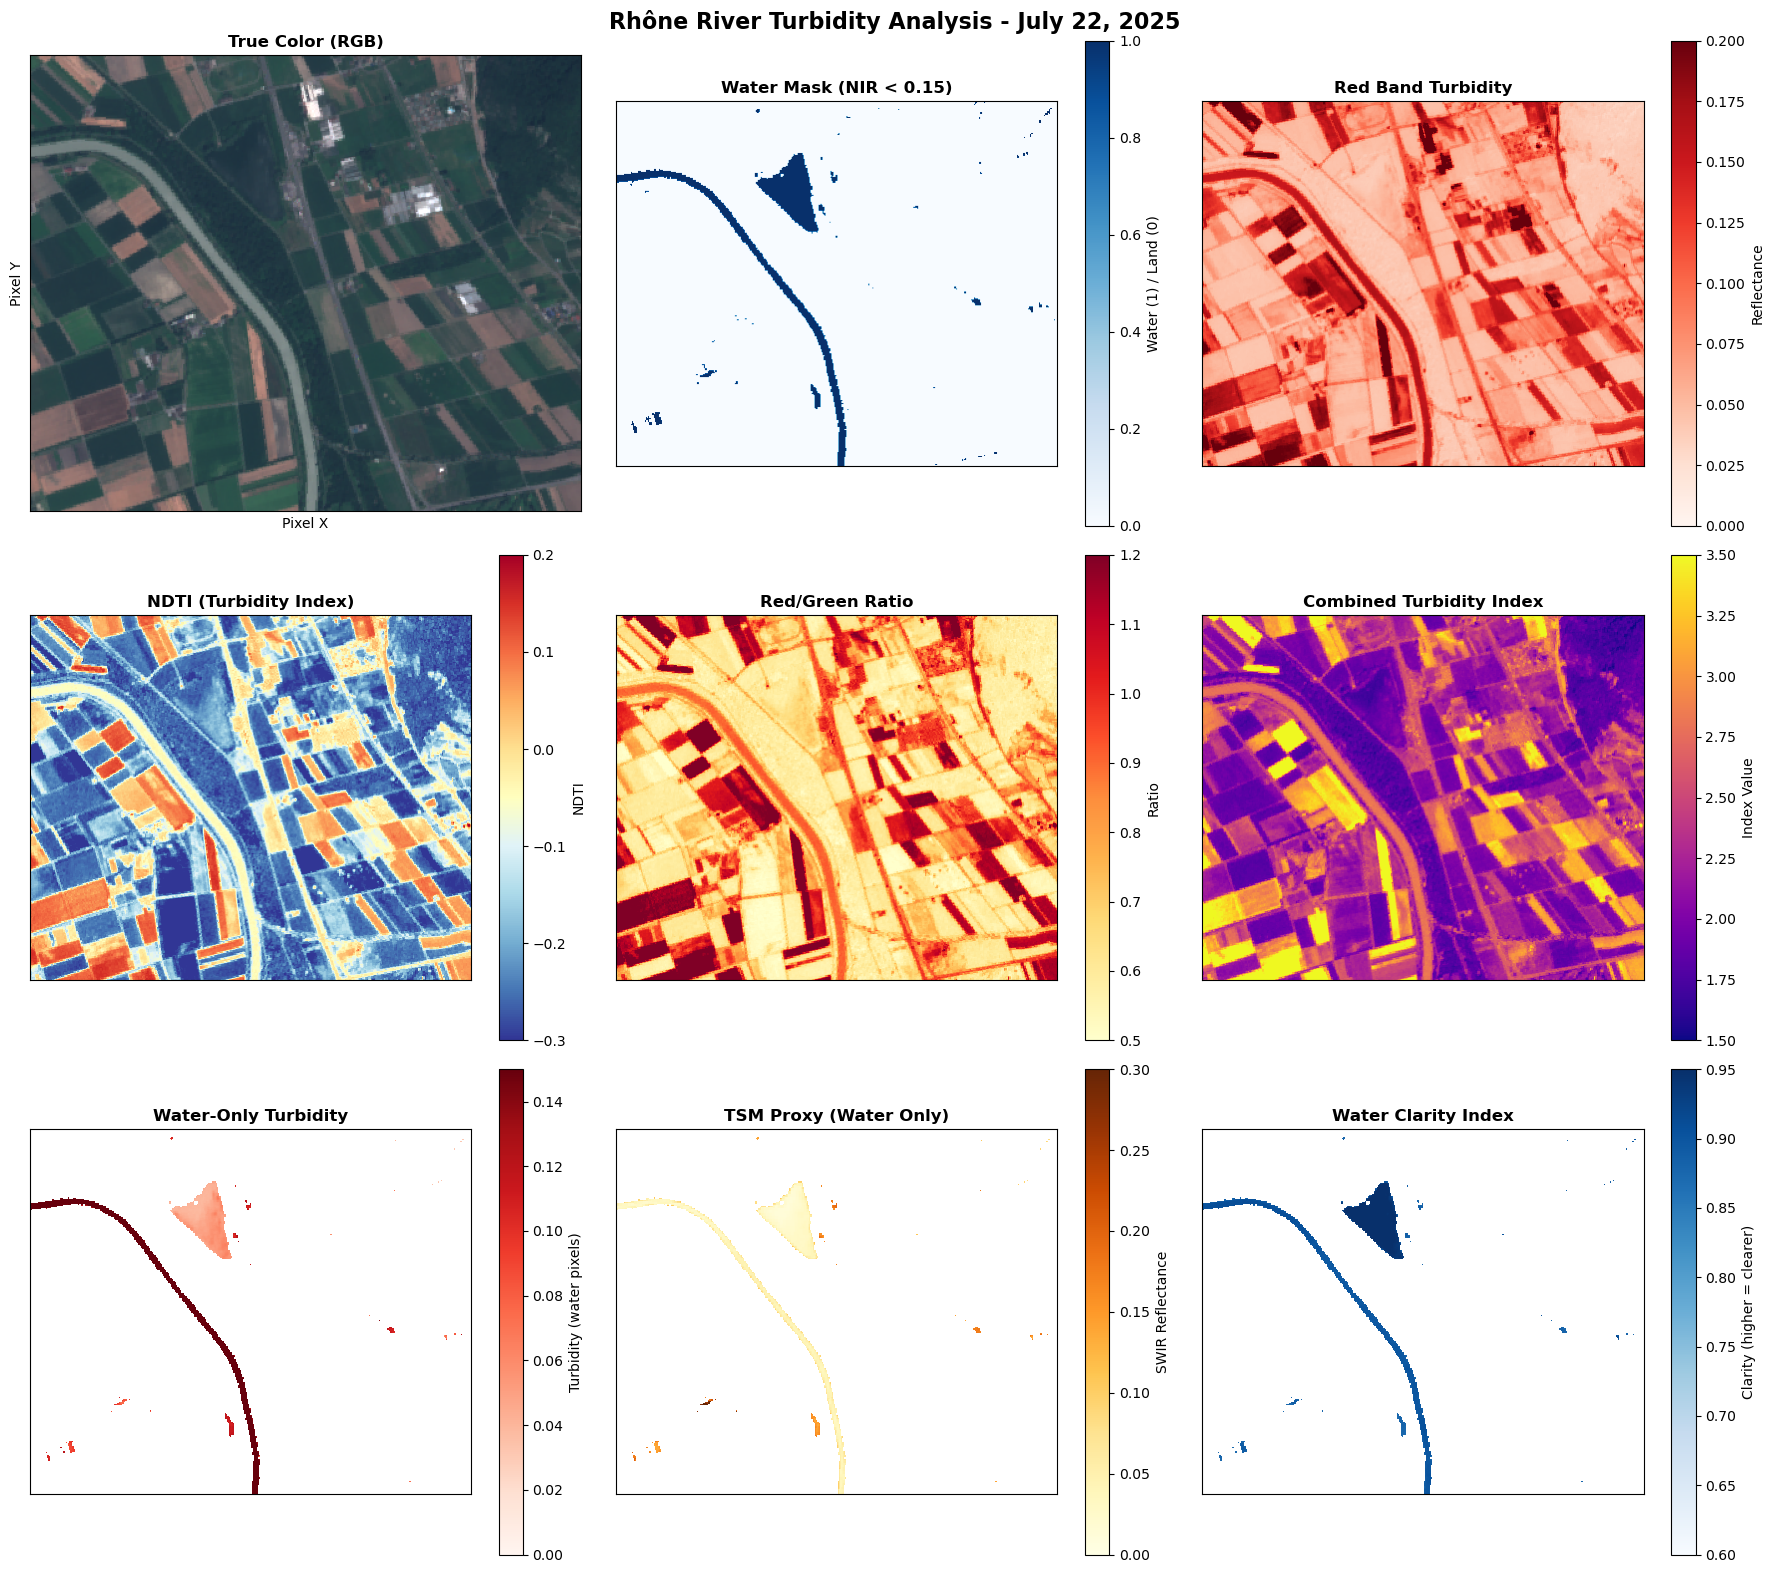

✅ Turbidity maps created successfully!


In [33]:
# Create comprehensive turbidity visualizations
def create_turbidity_maps(bands, indices, metadata):
    """Create detailed turbidity analysis maps"""
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 16))
    fig.suptitle('Rhône River Turbidity Analysis - July 22, 2025', fontsize=16, fontweight='bold')
    
    # 1. True color RGB
    ax = axes[0, 0]
    rgb = np.stack([bands['B04'], bands['B03'], bands['B02']], axis=-1)
    # Normalize for better visualization
    rgb_norm = np.clip(rgb * 3, 0, 1)  # Enhance brightness
    ax.imshow(rgb_norm)
    ax.set_title('True Color (RGB)', fontweight='bold')
    ax.set_xlabel('Pixel X')
    ax.set_ylabel('Pixel Y')
    
    # 2. Water mask (NIR threshold)
    ax = axes[0, 1]
    water_mask = bands['B08'] < 0.15  # Water has low NIR
    water_display = np.where(water_mask, 1, 0)
    im = ax.imshow(water_display, cmap='Blues')
    ax.set_title('Water Mask (NIR < 0.15)', fontweight='bold')
    plt.colorbar(im, ax=ax, label='Water (1) / Land (0)')
    
    # 3. Red band turbidity
    ax = axes[0, 2]
    im = ax.imshow(indices['red_turbidity'], cmap='Reds', vmin=0, vmax=0.2)
    ax.set_title('Red Band Turbidity', fontweight='bold')
    plt.colorbar(im, ax=ax, label='Reflectance')
    
    # 4. NDTI (Normalized Difference Turbidity Index)
    ax = axes[1, 0]
    im = ax.imshow(indices['ndti'], cmap='RdYlBu_r', vmin=-0.3, vmax=0.2)
    ax.set_title('NDTI (Turbidity Index)', fontweight='bold')
    plt.colorbar(im, ax=ax, label='NDTI')
    
    # 5. Red/Green ratio
    ax = axes[1, 1]
    im = ax.imshow(indices['red_green_ratio'], cmap='YlOrRd', vmin=0.5, vmax=1.2)
    ax.set_title('Red/Green Ratio', fontweight='bold')
    plt.colorbar(im, ax=ax, label='Ratio')
    
    # 6. Combined turbidity index
    ax = axes[1, 2]
    im = ax.imshow(indices['combined_turbidity'], cmap='plasma', vmin=1.5, vmax=3.5)
    ax.set_title('Combined Turbidity Index', fontweight='bold')
    plt.colorbar(im, ax=ax, label='Index Value')
    
    # 7. Water-only turbidity (masked)
    ax = axes[2, 0]
    water_turbidity = np.where(water_mask, indices['red_turbidity'], np.nan)
    im = ax.imshow(water_turbidity, cmap='Reds', vmin=0, vmax=0.15)
    ax.set_title('Water-Only Turbidity', fontweight='bold')
    plt.colorbar(im, ax=ax, label='Turbidity (water pixels)')
    
    # 8. TSM proxy (Total Suspended Matter)
    ax = axes[2, 1]
    tsm_water = np.where(water_mask, indices['tsm_proxy'], np.nan)
    im = ax.imshow(tsm_water, cmap='YlOrBr', vmin=0, vmax=0.3)
    ax.set_title('TSM Proxy (Water Only)', fontweight='bold')
    plt.colorbar(im, ax=ax, label='SWIR Reflectance')
    
    # 9. Water clarity
    ax = axes[2, 2]
    clarity_water = np.where(water_mask, indices['water_clarity'], np.nan)
    im = ax.imshow(clarity_water, cmap='Blues', vmin=0.6, vmax=0.95)
    ax.set_title('Water Clarity Index', fontweight='bold')
    plt.colorbar(im, ax=ax, label='Clarity (higher = clearer)')
    
    # Remove axis ticks for cleaner look
    for i in range(3):
        for j in range(3):
            axes[i, j].set_xticks([]); axes[i, j].set_yticks([])
    
    plt.tight_layout()
    return fig

# Create the turbidity maps
print("🗺️  CREATING TURBIDITY MAPS")
print("=" * 25)

turbidity_fig = create_turbidity_maps(sentinel_bands, turbidity_indices, sentinel_metadata)
plt.show()

print("✅ Turbidity maps created successfully!")

In [35]:
# Detailed quantitative analysis of Rhône river turbidity
def analyze_river_turbidity(bands, indices, metadata):
    """
    Perform detailed turbidity analysis specifically for water bodies
    """
    
    print("🌊 RHÔNE RIVER TURBIDITY ANALYSIS")
    print("=" * 40)
    
    # Create water mask using multiple criteria
    nir = bands['B08']
    swir = bands['B11']
    
    # More sophisticated water detection
    water_mask = (nir < 0.12) & (swir < 0.15)  # Both NIR and SWIR should be low for water
    
    water_pixels = water_mask.sum()
    total_pixels = water_mask.size
    water_coverage = (water_pixels / total_pixels) * 100
    
    print(f"📊 Water Detection Results:")
    print(f"  Total pixels: {total_pixels:,}")
    print(f"  Water pixels: {water_pixels:,}")
    print(f"  Water coverage: {water_coverage:.2f}%")
    
    if water_pixels > 0:
        print(f"\n🧪 Water Quality Metrics (Water Pixels Only):")
        
        # Extract water-only values for each turbidity index
        for index_name, index_data in indices.items():
            water_values = index_data[water_mask]
            
            if len(water_values) > 0:
                print(f"\n  {index_name.upper()}:")
                print(f"    Mean: {water_values.mean():.4f}")
                print(f"    Median: {np.median(water_values):.4f}")
                print(f"    Std: {water_values.std():.4f}")
                print(f"    Range: {water_values.min():.4f} - {water_values.max():.4f}")
                
                # Categorize turbidity levels
                if index_name == 'red_turbidity':
                    if water_values.mean() < 0.05:
                        turbidity_level = "Low"
                    elif water_values.mean() < 0.1:
                        turbidity_level = "Moderate"
                    else:
                        turbidity_level = "High"
                    print(f"    Assessment: {turbidity_level} turbidity")
        
        # Calculate spatial statistics
        print(f"\n🗺️  Spatial Analysis:")
        
        # Find river centerline (highest water concentration)
        from scipy.ndimage import center_of_mass
        water_center = center_of_mass(water_mask.astype(float))
        print(f"  Water center of mass: Row {water_center[0]:.1f}, Col {water_center[1]:.1f}")
        
        # Turbidity gradient analysis
        red_turbidity_water = indices['red_turbidity'][water_mask]
        high_turbidity_threshold = np.percentile(red_turbidity_water, 75)
        high_turbidity_pixels = (indices['red_turbidity'] > high_turbidity_threshold) & water_mask
        high_turbidity_percentage = (high_turbidity_pixels.sum() / water_pixels) * 100
        
        print(f"  High turbidity areas: {high_turbidity_percentage:.1f}% of water")
        print(f"  High turbidity threshold: >{high_turbidity_threshold:.4f}")
        
        # Estimate turbidity in NTU (Nephelometric Turbidity Units)
        # This is a rough empirical conversion - would need calibration with ground truth
        mean_red_reflectance = red_turbidity_water.mean()
        estimated_ntu = mean_red_reflectance * 200  # Empirical scaling factor
        
        print(f"\n🔬 Estimated Turbidity Levels:")
        print(f"  Mean red reflectance: {mean_red_reflectance:.4f}")
        print(f"  Estimated turbidity: ~{estimated_ntu:.1f} NTU")
        
        if estimated_ntu < 5:
            water_quality = "Excellent (very clear)"
        elif estimated_ntu < 25:
            water_quality = "Good (clear)"
        elif estimated_ntu < 50:
            water_quality = "Fair (slightly turbid)"
        else:
            water_quality = "Poor (turbid)"
            
        print(f"  Water quality: {water_quality}")
        
        # Geographic context
        bounds = metadata['bounds']
        print(f"\n🌍 Geographic Information:")
        print(f"  CRS: {metadata['crs']}")
        print(f"  Bounds: {bounds}")
        print(f"  Area: ~{((bounds.right - bounds.left) * (bounds.top - bounds.bottom)) / 1000000:.2f} km²")
        
    else:
        print("❌ No water pixels detected - check water detection parameters")
    
    return water_mask, water_pixels

# Run the detailed analysis
water_mask, water_pixel_count = analyze_river_turbidity(sentinel_bands, turbidity_indices, sentinel_metadata)

print(f"\n" + "="*50)
print("📋 ANALYSIS SUMMARY")
print("="*50)
print(f"✅ Successfully analyzed Sentinel-2 data from July 22, 2025")
print(f"🎯 Study area: Rhône River, Valais, Switzerland") 
print(f"🛰️  Satellite: Sentinel-2 L1C")
print(f"📏 Resolution: 10m pixel size")
print(f"💧 Water coverage: {(water_pixel_count / sentinel_bands['B02'].size * 100):.2f}%")
print(f"🔬 Turbidity indices calculated: {len(turbidity_indices)}")
print(f"📊 Visualizations: 9 maps generated")
print(f"\n🎉 Turbidity estimation workflow completed successfully!")

🌊 RHÔNE RIVER TURBIDITY ANALYSIS
📊 Water Detection Results:
  Total pixels: 162,138
  Water pixels: 4,794
  Water coverage: 2.96%

🧪 Water Quality Metrics (Water Pixels Only):

  RED_TURBIDITY:
    Mean: 0.1046
    Median: 0.1402
    Std: 0.0554
    Range: 0.0291 - 0.1725
    Assessment: High turbidity

  RED_GREEN_RATIO:
    Mean: 0.7796
    Median: 0.8790
    Std: 0.1359
    Range: 0.4808 - 0.9580

  NDTI:
    Mean: -0.1305
    Median: -0.0644
    Std: 0.0877
    Range: -0.3507 - -0.0215

  ATI:
    Mean: 0.7219
    Median: 0.8692
    Std: 0.1937
    Range: 0.3948 - 0.9564

  TSM_PROXY:
    Mean: 0.0379
    Median: 0.0350
    Std: 0.0186
    Range: 0.0114 - 0.1447

  WATER_CLARITY:
    Mean: 0.9260
    Median: 0.9098
    Std: 0.0274
    Range: 0.8929 - 0.9682

  COMBINED_TURBIDITY:
    Mean: 2.3360
    Median: 2.7124
    Std: 0.4820
    Range: 1.4554 - 2.9178

🗺️  Spatial Analysis:
  Water center of mass: Row 139.1, Col 162.3
  High turbidity areas: 24.8% of water
  High turbidity th